In [9]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
from __future__ import annotations
from typing import Any, Callable, List, Optional, Tuple

import os
import sys
sys.path.append("../") # So we can use the coordination package
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

from copy import deepcopy
import arviz as az
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import pandas as pd
import seaborn as sns

from coordination.model.real.brain import BrainModel
from coordination.model.config_bundle.brain import BrainBundle

# Style

In [11]:
sns.set_style("white")
tex_fonts = {
    "axes.labelsize": 8,
    "font.size": 8,
    "legend.fontsize": 8,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "axes.titlesize": 8,
    "axes.linewidth": 1
}
plt.rcParams.update(tex_fonts)
plt.rc('pdf',fonttype = 42)
plt.rcParams['text.usetex'] = True

# Use \showthe\textwidth
DOC_WIDTH = int(487.8225 / 2.1)

## Helper functions

In [12]:
def calculate_best_figure_dimensions(document_width: Union[str, float], scale=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.
    From: https://jwalton.info/Embed-Publication-Matplotlib-Latex/

    Parameters
    ----------
    document_width: Union[str, float]
            Document textwidth or columnwidth in pts. Predefined strings are also acceptable.
    scale: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    width_pt = document_width

    # Width of figure (in pts)
    fig_width_pt = width_pt * scale

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5 ** .5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt

    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return fig_width_in, fig_height_in

# Constants

In [13]:
# Plot
COLORS = ["#137513", "#FF9090", "#13B2FF"]
MUSTARD = "#BE9700"
SUBJECT_NAMES = ["Bob", "Alice", "Dan"]

# Reproducibility
SEED = 0

# Data 
T=30
BURN_IN = 2000
NUM_SAMPLES = 2000
NUM_CHAINS = 4

# Models

In [62]:
# Config bundle for a model of fNIRS with two features
def get_config_bundle(num_time_steps, 
                      coordination, 
                      constant_coordination, 
                      process_noise = 0, 
                      observation_noise = 0,
                      common_cause = False):
    bundle = BrainBundle()
    bundle.num_time_steps_in_coordination_scale = num_time_steps
    bundle.num_fnirs_channels = 2
    bundle.fnirs_channel_names = ["Channel1", "Channel2"]
    
    # Hyper-prior parameters
    bundle.sd_sd_uc = 0.1
    bundle.sd_mean_uc0 = 1.0
    bundle.sd_mean_a0 = 1.0
    bundle.fnirs_share_mean_a0_across_subjects = False
    bundle.fnirs_share_mean_a0_across_dimensions = False    
    bundle.common_cause = common_cause
    
    # Parameters
    bundle.mean_cc0 = np.array([[5.0, 10.0]])
    bundle.sd_cc=process_noise
    bundle.fnirs_mean_a0 = np.array([[0.0, 1.0], [0.0, 2.0], [0.0, 3.0]])
    bundle.fnirs_sd_a = process_noise
    bundle.fnirs_sd_o = observation_noise
    bundle.mean_uc0 = 0.0
    bundle.sd_uc = 1.0
        
    # Fix coordination samples so we can generate samples for a fixed coordination series.
    if constant_coordination:
        bundle.constant_coordination = True
        bundle.initial_coordination_samples = np.ones((1, num_time_steps)) * coordination
    else:
        if isinstance(coordination, np.ndarray):
            coordination_series = coordination
        else:
            coordination_series = np.ones(num_time_steps) * coordination
        bundle.initial_coordination_samples = coordination_series[None, :]

    return bundle


model_no_c = BrainModel(get_config_bundle(T, 0.2, False, process_noise = 0.5, observation_noise = 0, common_cause=True))

In [63]:
data_no_c = model_no_c.draw_samples()

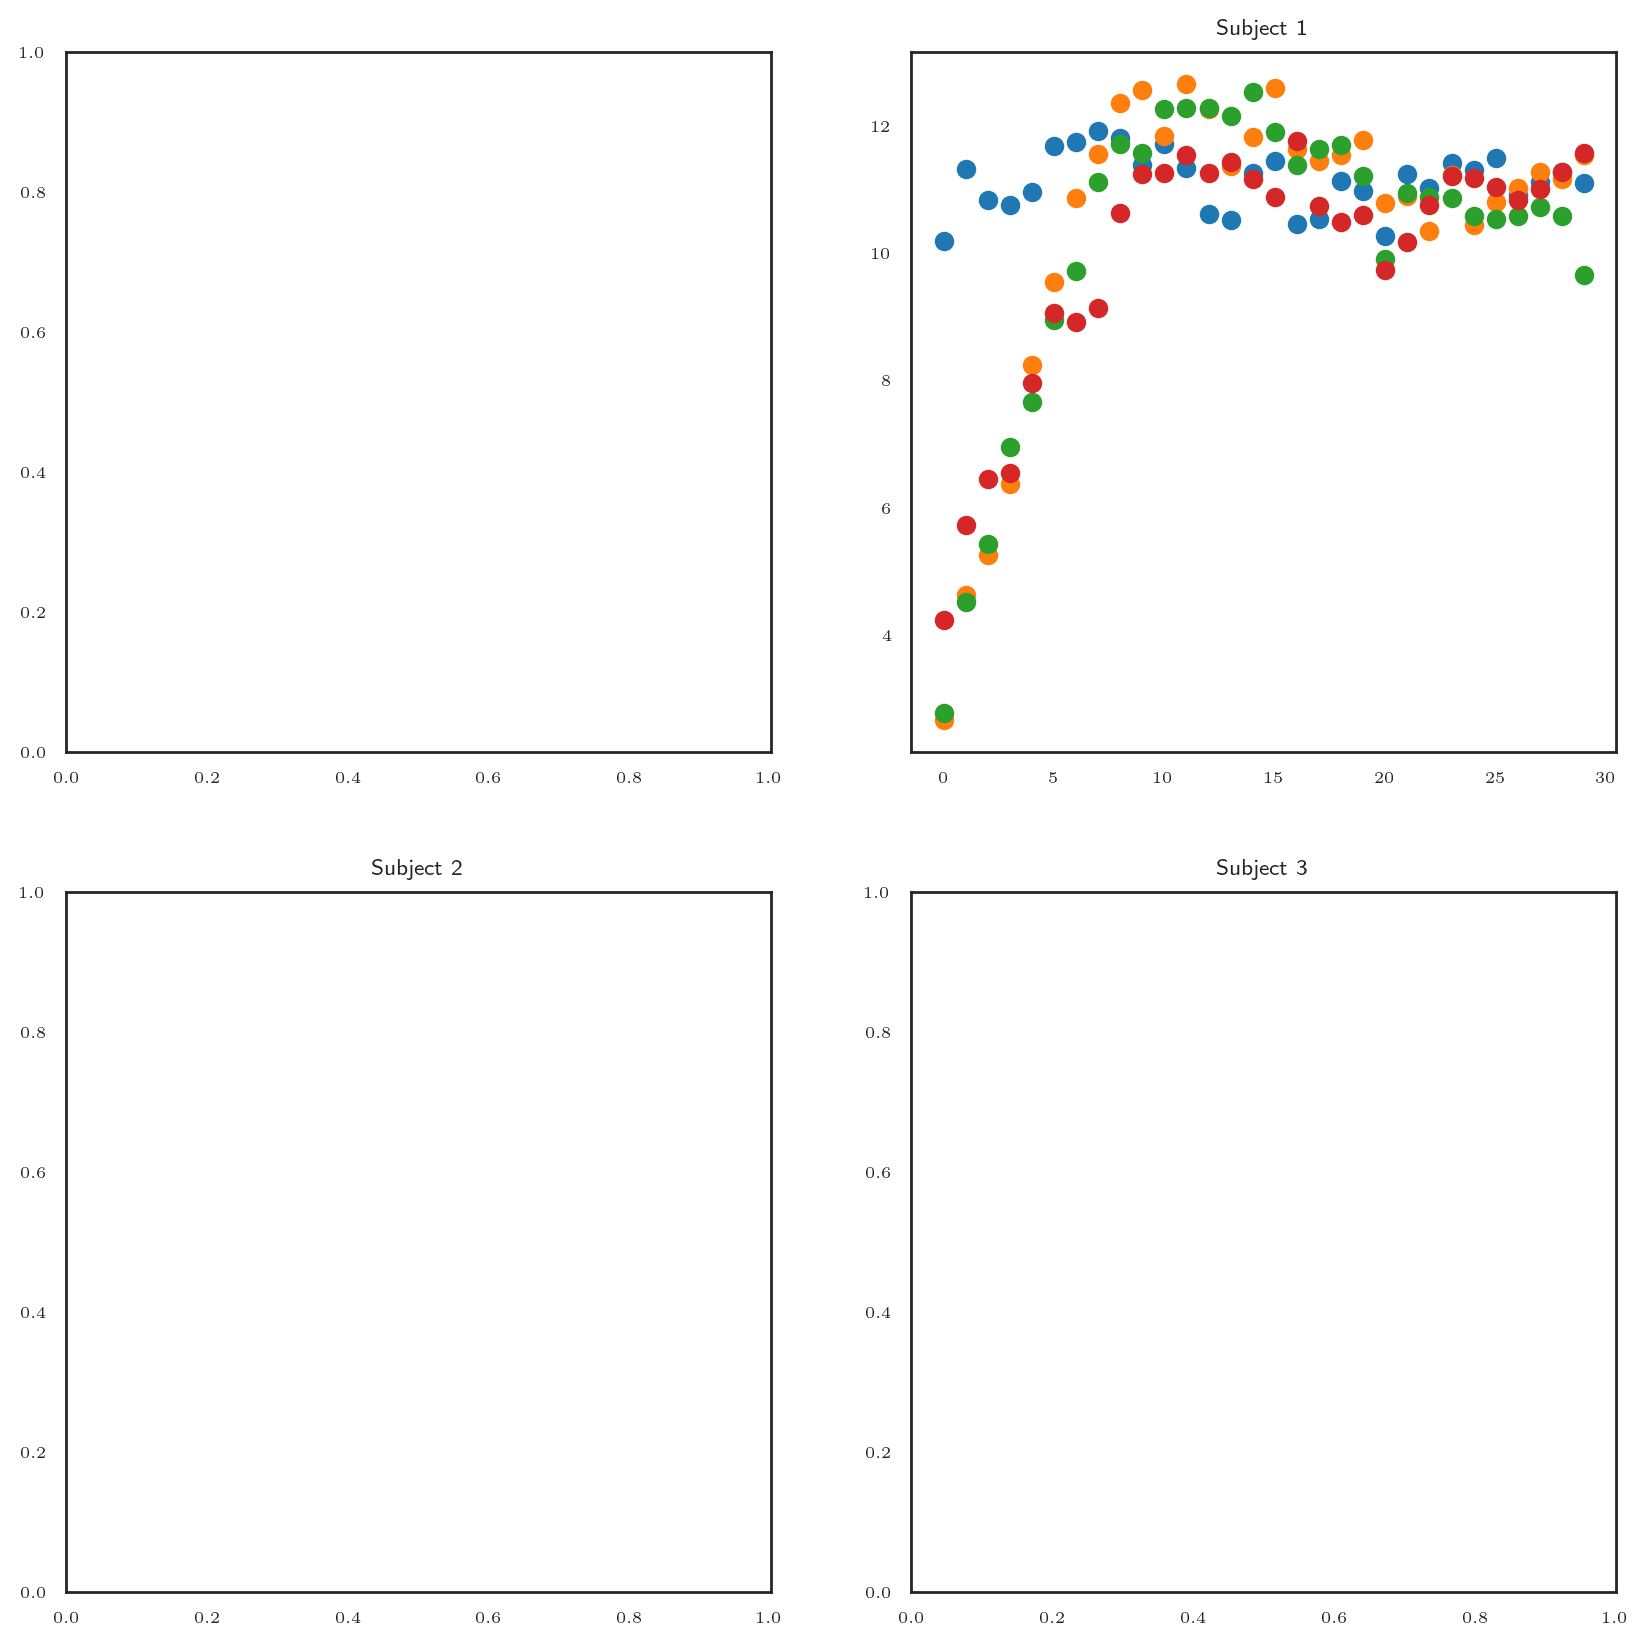

In [64]:
fig, axs = plt.subplots(2,2, figsize = (10,10))

# axs[0][0].set_title("Common Cause")
# axs[0][0].plot(range(T), data_no_c.component_group_samples['common_cause_fnirs_state_space'].values[0, 0, 0], "o", label="Position")
axs[0][1].plot(range(T), data_no_c.component_group_samples['common_cause_fnirs_state_space'].values[0, 0, 1], "o", label="Velocity")

axs[0][1].set_title("Subject 1")
# axs[0][1].plot(range(T), data_no_c.component_group_samples['fnirs_state_space'].values[0, 0, 0], "o", label="Position")
axs[0][1].plot(range(T), data_no_c.component_group_samples['fnirs_state_space'].values[0, 0, 1], "o", label="Velocity")

axs[1][0].set_title("Subject 2")
# axs[1][0].plot(range(T), data_no_c.component_group_samples['fnirs_state_space'].values[0, 1, 0], "o", label="Position")
axs[0][1].plot(range(T), data_no_c.component_group_samples['fnirs_state_space'].values[0, 1, 1], "o", label="Velocity")

axs[1][1].set_title("Subject 3")
# axs[1][1].plot(range(T), data_no_c.component_group_samples['fnirs_state_space'].values[0, 2, 0], "o", label="Position")
axs[0][1].plot(range(T), data_no_c.component_group_samples['fnirs_state_space'].values[0, 2, 1], "o", label="Velocity")

# Synthetic Data

In [ ]:
def plot_observations(samples, ax, dim = 0, dim_name = "Pitch", **kwargs):
    time_map = samples.component_group_samples["state_space"].time_steps_in_coordination_scale[0]
    subject_indices = samples.component_group_samples["speech_vocalics"].subject_indices[0]
    values = samples.component_group_samples["speech_vocalics"].values[0]
    for subject in range(3):
        ts_idx = np.array([t for t, s in enumerate(subject_indices) if s == subject])
        ts = np.array([time_map[t] for t in ts_idx])
        ys = values[dim, ts_idx]
        ax.plot(ts, ys, label=SUBJECT_NAMES[subject], marker="o", linestyle="--", linewidth=0.5, color=COLORS[subject], **kwargs)   
        ax.set_xlabel("Time Step")
        ax.set_ylabel(dim_name)

# Plot data
w, h = calculate_best_figure_dimensions(document_width=DOC_WIDTH, scale=1, subplots=(2,2))  
fig, axs = plt.subplots(2, 2, figsize=(w,h*1.5))
axs[0,1].sharey(axs[0,0])
axs[1,1].sharey(axs[1,0])

x_slice = [0, 20]

data_no_c = model_no_c.draw_samples()
data_low_c = model_low_c.draw_samples()
data_high_c = model_high_c.draw_samples()

plot_observations(data_no_c, axs[0, 0], markersize=3)
plot_observations(data_low_c, axs[0, 1], markersize=3)
plot_observations(data_high_c, axs[1, 0], markersize=3)

axs[0,0].set_xlim(x_slice)
axs[0,1].set_xlim(x_slice)
axs[1,0].set_xlim(x_slice)
axs[0,1].set_ylabel("")
plt.tight_layout()

# Experiments

## Helper Functions

In [ ]:
def train(model, burn_in, num_samples, num_chains) -> InferenceData:
    # Clone the model so we can create new random variables for it.
    model.prepare_for_inference()    
    idata = model.fit(burn_in = burn_in, num_samples = num_samples, num_chains = num_chains)

    # Plot coordination
    w, h = calculate_best_figure_dimensions(document_width=DOC_WIDTH, scale=1)  
    fig = plt.figure(figsize=(w,h))
    idata.plot_time_series_posterior(ax=fig.gca(), variable_name="coordination", include_bands=True, value_bounds=(0, 1), marker=None)
    idata.plot_parameter_posterior()
    print(idata.generate_convergence_summary())
    return idata

def run_inference(model, process_noise=0.01, observation_noise=1.0, burn_in=BURN_IN, num_samples=NUM_SAMPLES, num_chains=NUM_CHAINS, clear_vars=True):
    bundle = deepcopy(model.config_bundle)
    bundle.sd_a = process_noise
    bundle.sd_o = observation_noise
    bundle.observation_normalization = "norm_per_feature"
    # bundle.sd_mean_uc0 = 5.0
    # bundle.sd_sd_uc = 0.5
    cloned_model = type(model)(bundle)
    samples = cloned_model.draw_samples()
    update_config_bundle_from_samples(cloned_model.config_bundle, samples)

    if clear_vars:
        bundle.mean_uc0=None
        bundle.sd_uc=None
        bundle.mean_a0=None
        bundle.sd_a=None
        bundle.sd_o=None
        # Because features are normalized, we can fix the weights to unitary scale
        cloned_model.config_bundle.weights = [np.ones((1,2))]  

    idata = train(cloned_model, burn_in, num_samples, num_chains)
    return idata, samples    

def update_config_bundle_from_samples(config_bundle, samples):
    # Metadata
    config_bundle.prev_time_diff_subject = samples.component_group_samples["state_space"].prev_time_diff_subject[0]
    config_bundle.prev_time_same_subject = samples.component_group_samples["state_space"].prev_time_same_subject[0]
    config_bundle.subject_indices = samples.component_group_samples["speech_vocalics"].subject_indices[0]
    config_bundle.time_steps_in_coordination_scale = samples.component_group_samples["speech_vocalics"].time_steps_in_coordination_scale[0]

    # Data
    config_bundle.observed_values = samples.component_group_samples["speech_vocalics"].values[0]

# Inference

## C = 0

In [ ]:
idata_no_c, noisy_data_no_c = run_inference(model_no_c)

## C = 0.25

In [ ]:
idata_low_c, noisy_data_low_c = run_inference(model_low_c)

## C = 0.75

In [ ]:
idata_high_c, noisy_data_high_c = run_inference(model_high_c)

# Final Plot

In [ ]:
def custom_formatter(x, pos):
    result = x
    if result == 0:
        return '0'
    # If not 0, format as multiples of 1000 (1K, 2K, 3K, etc.)
    return f'{result/1000:.1f}K'

def save_plot(image_name: str, fig: Any, format: str = "pdf"):
    fig.savefig(f"../assets/images/{image_name}.{format}", format=format, bbox_inches='tight', pad_inches=0)

In [ ]:
w, h = calculate_best_figure_dimensions(document_width=DOC_WIDTH, scale=1, subplots=(2,2))  
fig, axs = plt.subplots(2, 2, figsize=(w, h*1.5))

x_slice = [-1, 30]
marker_size = 3

axs[0,1].sharey(axs[0,0])
# axs[1,1].sharey(axs[1,0])
sns.despine(ax=axs[0,0])
sns.despine(ax=axs[0,1])
sns.despine(ax=axs[1,0])
sns.despine(ax=axs[1,1])

# Data plots
plot_observations(data_no_c, axs[0, 0], markersize=marker_size)
axs[0,0].set_ylabel("Pitch")
axs[0,0].set_xlabel("Time Step")
axs[0,0].set_title("Data (c = 0)")
axs[0,0].set_xlim(x_slice)

plot_observations(data_low_c, axs[0, 1], markersize=marker_size)
axs[0,1].set_ylabel("")
axs[0,1].set_xlabel("Time Step")
axs[0,1].set_title("Data (c = 0.25)")
axs[0,1].set_xlim(x_slice)

plot_observations(data_high_c, axs[1, 0], markersize=marker_size)
axs[1,0].set_ylabel("Pitch")
axs[1,0].set_xlabel("Time Step")
axs[1,0].set_title("Data (c = 0.75)")
axs[1,0].set_xlim(x_slice)

idata_no_c.plot_time_series_posterior("coordination", True, ax=axs[1,1], marker=None, linewidth=1, color="tab:red", label="c = 0")
idata_low_c.plot_time_series_posterior("coordination", True, ax=axs[1,1], marker=None, linewidth=1, color=MUSTARD, label="c = 0.25")
idata_high_c.plot_time_series_posterior("coordination", True, ax=axs[1,1], marker=None, linewidth=1, color="tab:blue", label="c = 0.75")
axs[1,1].set_title("Inferred Coordination")
axs[1,1].set_xlabel("")
axs[1,1].set_ylabel("Coordination")
axs[1,1].set_xlabel("Time Step")
axs[1,1].set_ylim([0,1])

handles, labels = axs[0,0].get_legend_handles_labels()
leg = fig.legend(handles, labels, loc='lower right', ncol=3, bbox_to_anchor=[0.83, -0.13], frameon=False, markerscale=1, columnspacing=1.4, title="Speaker")

handles, labels = axs[1,1].get_legend_handles_labels()
leg = fig.legend(handles, labels, loc='lower right', ncol=3, bbox_to_anchor=[0.91, -0.25], frameon=False, markerscale=1, columnspacing=1.4, title="Coordination")

plt.tight_layout()
save_plot("results_vocalic_model", fig, "png")
save_plot("results_vocalic_model", fig, "pdf")